# Demand Confidence Forecasting - FULL MODEL

## A. Fernandes, 09/30/21

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import SGD


import pandas as pd
import plotly.express as px
import plotly.colors as c
import plotly.graph_objects as go
from numpy import array
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Bidirectional, Input, GRU, TimeDistributed, Conv1D, Flatten, MaxPooling1D
from keras.layers import Dense
import tensorflow as tf
import numpy as np
import keras.backend as K
import gc

from tensorflow.keras import layers
from tensorflow.keras import initializers

In [2]:
df = pd.read_csv("demand-forecasting-kernels-only/train.csv")
#df = df.loc[df.store < 3].loc[df.item < 3]
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
print(df.shape)
print(df.columns)

(913000, 4)
Index(['date', 'store', 'item', 'sales'], dtype='object')


In [4]:
df.index = pd.to_datetime(df['date'])
df.head()

,date,store,item,sales
date,,,,
2013-01-01,2013-01-01,1,1,13
2013-01-02,2013-01-02,1,1,11
2013-01-03,2013-01-03,1,1,14
2013-01-04,2013-01-04,1,1,13
2013-01-05,2013-01-05,1,1,10


<AxesSubplot:xlabel='date'>

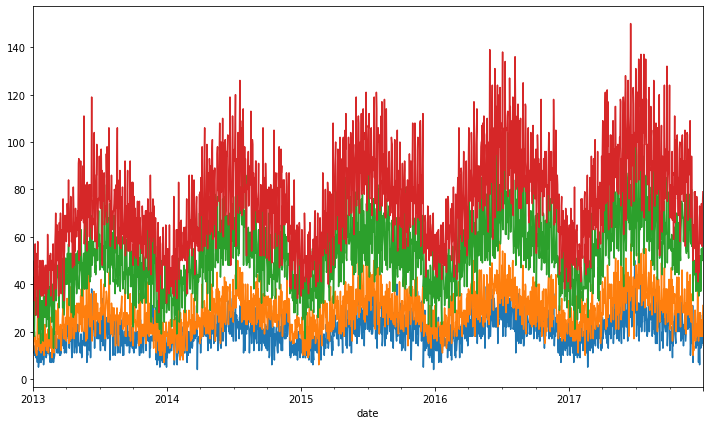

In [5]:
plt.figure(figsize=(12,7))
df['sales'].loc[(df.item == 1) & (df.store == 1)].plot()
df['sales'].loc[(df.item == 1) & (df.store == 2)].plot()
df['sales'].loc[(df.item == 2) & (df.store == 1)].plot()
df['sales'].loc[(df.item == 2) & (df.store == 2)].plot()

## Build Train-Test Datasets

#### Now, Let's divide the data into a training and test set. Once done so, we can plot both on the same figure in order to get a feeling of how does our Time Series looks like

In [6]:
train_data, test_data = df.loc['2013':'2016'], df.loc['2017']

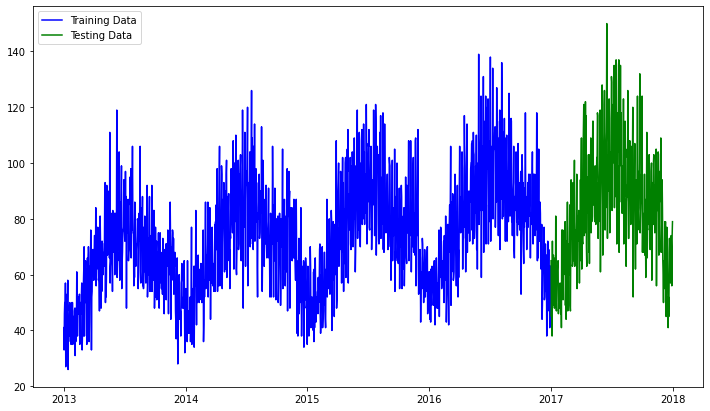

In [7]:
item = 2
store = 2

plt.figure(figsize=(12,7))
plt.plot(train_data['sales'].loc[(train_data.item == item) & (train_data.store == store)], 'blue', label='Training Data')
plt.plot(test_data['sales'].loc[(test_data.item == item) & (test_data.store == store)], 'green', label='Testing Data')
plt.legend();

In [8]:
nT = len(train_data['sales'].loc[(train_data.item == item) & (train_data.store == store)])
N_Items = 50
N_Stores = 10
features = N_Items*N_Stores
train_series_arr = np.zeros([nT,features])
cc = 0
Item_Store_Coordinates = []
for item in range(1,N_Items + 1):
    for store in range(1,N_Stores + 1):
        train_series_arr[:,cc] = train_data['sales'].loc[(train_data.item == item) & (train_data.store == store)]
        Item_Store_Coordinates.append([cc,item,store])
        cc += 1
train_series_arr.shape
test_index = test_data.loc[(test_data.item == item) & (test_data.store == store)].index
Item_Store_Coordinates = pd.DataFrame(Item_Store_Coordinates)
Item_Store_Coordinates.columns = ['idx','item','store']

In [9]:
sc = MinMaxScaler(feature_range=(-1,1))
training_set_scaled = sc.fit_transform(train_series_arr)
training_set_scaled.shape

(1461, 500)

In [10]:
seq_length = 365
out_seq_length = 365

X_train = []
y_train = []
for i in range(seq_length, len(training_set_scaled) - out_seq_length):
    X_train.append(training_set_scaled[i-seq_length:i,:])
    y_train.append(training_set_scaled[i : i+out_seq_length,:])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((731, 365, 500), (731, 365, 500))

In [11]:
#####################################################################################################

In [12]:
####################################################################################################

In [11]:
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev= 1.0)
LAYER_SIZE = 256
PRED_CURVES = []
for cc in range(0,30):
    
    input_data = Input(shape=(X_train.shape[1],X_train.shape[2]))
    lstm1 = LSTM(LAYER_SIZE,
                 return_sequences = True)
    lstm2 = LSTM(LAYER_SIZE,
                 return_sequences = True)
    dense = TimeDistributed(Dense(X_train.shape[2], 
                                  activation='linear',
                                  kernel_initializer= initializer))

    lstm1_outputs = lstm1(input_data)
    lstm2_outputs = lstm2(lstm1_outputs)
    dense_out = dense(lstm2_outputs)

    regressor = Model(inputs=[input_data],outputs=[dense_out])
    regressor.compile(optimizer='RMSprop', 
                      loss='mean_squared_error')

    print(regressor.summary())

    regressor.fit(X_train,
                  y_train, 
                  epochs=30, 
                  batch_size=64, 
                  validation_split=0.1)
    
    pred_curves = []
    train_last_seq = train_series_arr[-seq_length:]
    F = np.copy(sc.transform(train_last_seq)).reshape((1, seq_length, X_train.shape[2]))
    pred = regressor.predict(F)
    for curve in range(0,X_train.shape[2]):
        pred_curve = pd.DataFrame(sc.inverse_transform(pred[0,:,:])[:,curve].ravel())
        pred_curve.index = test_index
        pred_curves.append(pred_curve)
    PRED_CURVES.append(pred_curves)
    
#PRED_CURVES(model_number,curvenumber,data)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 365, 500)]        0         
_________________________________________________________________
lstm (LSTM)                  (None, 365, 256)          775168    
_________________________________________________________________
lstm_1 (LSTM)                (None, 365, 256)          525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 365, 500)          128500    
Total params: 1,428,980
Trainable params: 1,428,980
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
11/11 [==============================] - 6s 214ms/step - loss: 3.5878 - val_loss: 0.3172
Epoch 2/30
11/11 [==============================] - 1s 90ms/step - loss: 0.2610 - val_loss: 0.2790
Epoch 3/30
11/11 [===========================

Epoch 1/30
11/11 [==============================] - 4s 150ms/step - loss: 3.2180 - val_loss: 0.4632
Epoch 2/30
11/11 [==============================] - 1s 91ms/step - loss: 0.2897 - val_loss: 0.2991
Epoch 3/30
11/11 [==============================] - 1s 90ms/step - loss: 0.2535 - val_loss: 0.2227
Epoch 4/30
11/11 [==============================] - 1s 100ms/step - loss: 0.1996 - val_loss: 0.2192
Epoch 5/30
11/11 [==============================] - 1s 94ms/step - loss: 0.1671 - val_loss: 0.1619
Epoch 6/30
11/11 [==============================] - 1s 94ms/step - loss: 0.1397 - val_loss: 0.1374
Epoch 7/30
11/11 [==============================] - 1s 93ms/step - loss: 0.1205 - val_loss: 0.1273
Epoch 8/30
11/11 [==============================] - 1s 91ms/step - loss: 0.1127 - val_loss: 0.1078
Epoch 9/30
11/11 [==============================] - 1s 89ms/step - loss: 0.0987 - val_loss: 0.1022
Epoch 10/30
11/11 [==============================] - 1s 91ms/step - loss: 0.0890 - val_loss: 0.0917
Epoch 1

Epoch 1/30
11/11 [==============================] - 4s 146ms/step - loss: 3.7558 - val_loss: 0.3171
Epoch 2/30
11/11 [==============================] - 1s 93ms/step - loss: 0.2925 - val_loss: 0.3058
Epoch 3/30
11/11 [==============================] - 1s 92ms/step - loss: 0.2324 - val_loss: 0.2250
Epoch 4/30
11/11 [==============================] - 1s 90ms/step - loss: 0.1902 - val_loss: 0.2308
Epoch 5/30
11/11 [==============================] - 1s 90ms/step - loss: 0.1789 - val_loss: 0.1796
Epoch 6/30
11/11 [==============================] - 1s 88ms/step - loss: 0.1485 - val_loss: 0.1423
Epoch 7/30
11/11 [==============================] - 1s 91ms/step - loss: 0.1332 - val_loss: 0.1242
Epoch 8/30
11/11 [==============================] - 1s 90ms/step - loss: 0.1132 - val_loss: 0.1171
Epoch 9/30
11/11 [==============================] - 1s 91ms/step - loss: 0.1043 - val_loss: 0.1067
Epoch 10/30
11/11 [==============================] - 1s 93ms/step - loss: 0.0904 - val_loss: 0.0947
Epoch 11

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 365, 500)]        0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 365, 256)          775168    
_________________________________________________________________
lstm_17 (LSTM)               (None, 365, 256)          525312    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 365, 500)          128500    
Total params: 1,428,980
Trainable params: 1,428,980
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
11/11 [==============================] - 4s 143ms/step - loss: 3.1860 - val_loss: 0.4199
Epoch 2/30
11/11 [==============================] - 1s 87ms/step - loss: 0.2968 - val_loss: 0.2939
Epoch 3/30
11/11 [=========================

Epoch 28/30
11/11 [==============================] - 1s 88ms/step - loss: 0.0424 - val_loss: 0.0454
Epoch 29/30
11/11 [==============================] - 1s 90ms/step - loss: 0.0424 - val_loss: 0.0447
Epoch 30/30
11/11 [==============================] - 1s 80ms/step - loss: 0.0402 - val_loss: 0.0464
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 365, 500)]        0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 365, 256)          775168    
_________________________________________________________________
lstm_21 (LSTM)               (None, 365, 256)          525312    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 365, 500)          128500    
Total params: 1,428,980
Trainable params: 1,428,980
Non-trainable params: 0
____________

11/11 [==============================] - 1s 91ms/step - loss: 0.1540 - val_loss: 0.1918
Epoch 7/30
11/11 [==============================] - 1s 91ms/step - loss: 0.1359 - val_loss: 0.1335
Epoch 8/30
11/11 [==============================] - 1s 91ms/step - loss: 0.1201 - val_loss: 0.1199
Epoch 9/30
11/11 [==============================] - 1s 89ms/step - loss: 0.1049 - val_loss: 0.1053
Epoch 10/30
11/11 [==============================] - 1s 93ms/step - loss: 0.0958 - val_loss: 0.0910
Epoch 11/30
11/11 [==============================] - 1s 92ms/step - loss: 0.0815 - val_loss: 0.0912
Epoch 12/30
11/11 [==============================] - 1s 90ms/step - loss: 0.0793 - val_loss: 0.0854
Epoch 13/30
11/11 [==============================] - 1s 92ms/step - loss: 0.0721 - val_loss: 0.0742
Epoch 14/30
11/11 [==============================] - 1s 91ms/step - loss: 0.0706 - val_loss: 0.0670
Epoch 15/30
11/11 [==============================] - 1s 90ms/step - loss: 0.0643 - val_loss: 0.0742
Epoch 16/30
11/

Epoch 1/30
11/11 [==============================] - 4s 150ms/step - loss: 3.4964 - val_loss: 0.3962
Epoch 2/30
11/11 [==============================] - 1s 89ms/step - loss: 0.3200 - val_loss: 0.3394
Epoch 3/30
11/11 [==============================] - 1s 91ms/step - loss: 0.2485 - val_loss: 0.3471
Epoch 4/30
11/11 [==============================] - 1s 91ms/step - loss: 0.1976 - val_loss: 0.1799
Epoch 5/30
11/11 [==============================] - 1s 94ms/step - loss: 0.1672 - val_loss: 0.1915
Epoch 6/30
11/11 [==============================] - 1s 90ms/step - loss: 0.1476 - val_loss: 0.1578
Epoch 7/30
11/11 [==============================] - 1s 88ms/step - loss: 0.1361 - val_loss: 0.1277
Epoch 8/30
11/11 [==============================] - 1s 88ms/step - loss: 0.1099 - val_loss: 0.1139
Epoch 9/30
11/11 [==============================] - 1s 88ms/step - loss: 0.1033 - val_loss: 0.0971
Epoch 10/30
11/11 [==============================] - 1s 87ms/step - loss: 0.0901 - val_loss: 0.0899
Epoch 11

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 365, 500)]        0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 365, 256)          775168    
_________________________________________________________________
lstm_35 (LSTM)               (None, 365, 256)          525312    
_________________________________________________________________
time_distributed_17 (TimeDis (None, 365, 500)          128500    
Total params: 1,428,980
Trainable params: 1,428,980
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
11/11 [==============================] - 4s 151ms/step - loss: 3.7591 - val_loss: 0.3333
Epoch 2/30
11/11 [==============================] - 1s 95ms/step - loss: 0.2568 - val_loss: 0.3245
Epoch 3/30
11/11 [========================

Epoch 28/30
11/11 [==============================] - 1s 88ms/step - loss: 0.0424 - val_loss: 0.0485
Epoch 29/30
11/11 [==============================] - 1s 87ms/step - loss: 0.0428 - val_loss: 0.0433
Epoch 30/30
11/11 [==============================] - 1s 76ms/step - loss: 0.0417 - val_loss: 0.0419
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 365, 500)]        0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 365, 256)          775168    
_________________________________________________________________
lstm_39 (LSTM)               (None, 365, 256)          525312    
_________________________________________________________________
time_distributed_19 (TimeDis (None, 365, 500)          128500    
Total params: 1,428,980
Trainable params: 1,428,980
Non-trainable params: 0
____________

11/11 [==============================] - 1s 89ms/step - loss: 0.1523 - val_loss: 0.1582
Epoch 7/30
11/11 [==============================] - 1s 88ms/step - loss: 0.1247 - val_loss: 0.1308
Epoch 8/30
11/11 [==============================] - 1s 89ms/step - loss: 0.1142 - val_loss: 0.1083
Epoch 9/30
11/11 [==============================] - 1s 90ms/step - loss: 0.0993 - val_loss: 0.0978
Epoch 10/30
11/11 [==============================] - 1s 92ms/step - loss: 0.0915 - val_loss: 0.0891
Epoch 11/30
11/11 [==============================] - 1s 88ms/step - loss: 0.0818 - val_loss: 0.0795
Epoch 12/30
11/11 [==============================] - 1s 86ms/step - loss: 0.0735 - val_loss: 0.0833
Epoch 13/30
11/11 [==============================] - 1s 91ms/step - loss: 0.0717 - val_loss: 0.0733
Epoch 14/30
11/11 [==============================] - 1s 94ms/step - loss: 0.0683 - val_loss: 0.0672
Epoch 15/30
11/11 [==============================] - 1s 89ms/step - loss: 0.0623 - val_loss: 0.0636
Epoch 16/30
11/

Epoch 1/30
11/11 [==============================] - 4s 151ms/step - loss: 3.6528 - val_loss: 0.3836
Epoch 2/30
11/11 [==============================] - 1s 92ms/step - loss: 0.2934 - val_loss: 0.3287
Epoch 3/30
11/11 [==============================] - 1s 93ms/step - loss: 0.2407 - val_loss: 0.2337
Epoch 4/30
11/11 [==============================] - 1s 91ms/step - loss: 0.1899 - val_loss: 0.2319
Epoch 5/30
11/11 [==============================] - 1s 95ms/step - loss: 0.1632 - val_loss: 0.1782
Epoch 6/30
11/11 [==============================] - 1s 90ms/step - loss: 0.1432 - val_loss: 0.1470
Epoch 7/30
11/11 [==============================] - 1s 88ms/step - loss: 0.1214 - val_loss: 0.1344
Epoch 8/30
11/11 [==============================] - 1s 90ms/step - loss: 0.1151 - val_loss: 0.1104
Epoch 9/30
11/11 [==============================] - 1s 92ms/step - loss: 0.0989 - val_loss: 0.0945
Epoch 10/30
11/11 [==============================] - 1s 93ms/step - loss: 0.0860 - val_loss: 0.0936
Epoch 11

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 365, 500)]        0         
_________________________________________________________________
lstm_52 (LSTM)               (None, 365, 256)          775168    
_________________________________________________________________
lstm_53 (LSTM)               (None, 365, 256)          525312    
_________________________________________________________________
time_distributed_26 (TimeDis (None, 365, 500)          128500    
Total params: 1,428,980
Trainable params: 1,428,980
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
11/11 [==============================] - 4s 163ms/step - loss: 3.8342 - val_loss: 0.4668
Epoch 2/30
11/11 [==============================] - 1s 92ms/step - loss: 0.2956 - val_loss: 0.2961
Epoch 3/30
11/11 [========================

Epoch 28/30
11/11 [==============================] - 1s 89ms/step - loss: 0.0448 - val_loss: 0.0457
Epoch 29/30
11/11 [==============================] - 1s 88ms/step - loss: 0.0441 - val_loss: 0.0434
Epoch 30/30
11/11 [==============================] - 1s 80ms/step - loss: 0.0420 - val_loss: 0.0436
Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 365, 500)]        0         
_________________________________________________________________
lstm_56 (LSTM)               (None, 365, 256)          775168    
_________________________________________________________________
lstm_57 (LSTM)               (None, 365, 256)          525312    
_________________________________________________________________
time_distributed_28 (TimeDis (None, 365, 500)          128500    
Total params: 1,428,980
Trainable params: 1,428,980
Non-trainable params: 0
____________

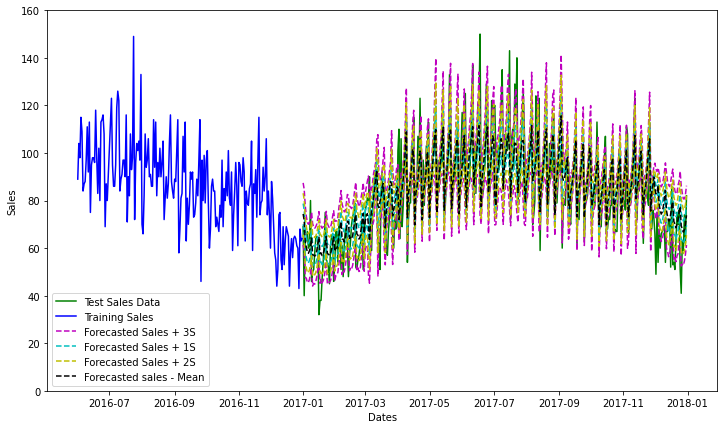

In [15]:
item = 50
store = 10

N = list(Item_Store_Coordinates.idx.loc[(Item_Store_Coordinates.store == store) &
                                        (Item_Store_Coordinates.item == item)])[0]
ensemble = []
for pred in PRED_CURVES:
    ensemble.append(list(pred[N][0]))
ensemble = pd.DataFrame(ensemble).transpose()
ensemble.index = pred[0].index

train_series = train_data['sales'].loc[(train_data.item == item) & (train_data.store == store)]
test_series = test_data['sales'].loc[(test_data.item == item) & (test_data.store == store)]

# plt.figure(figsize=(12,7))
# plt.xlabel('Dates')
# plt.ylabel('Sales')
# plt.plot(train_series, color='blue', label='Training Sales')
# plt.plot(test_series, color='green', label='Testing Sales')
# plt.plot(ensemble.mean(axis = 1), color='red', linestyle='--', label='Forecasted Sales')
# plt.legend();

plt.figure(figsize=(12,7))
plt.xlabel('Dates')
plt.ylabel('Sales')
plt.plot(test_series, color='green', label='Test Sales Data')
plt.plot(train_series['2016-06-01':], color='blue', label='Training Sales')
plt.plot(ensemble.mean(axis = 1) + 3*ensemble.std(axis = 1), color='m',linestyle='--', label='Forecasted Sales + 3S')
plt.plot(ensemble.mean(axis = 1) -3*ensemble.std(axis = 1), color='m',linestyle='--')
plt.plot(ensemble.mean(axis = 1) + 1*ensemble.std(axis = 1), color='c',linestyle='--', label='Forecasted Sales + 1S')
plt.plot(ensemble.mean(axis = 1) -1*ensemble.std(axis = 1), color='c',linestyle='--')
plt.plot(ensemble.mean(axis = 1) + 2*ensemble.std(axis = 1), color='y',linestyle='--', label='Forecasted Sales + 2S')
plt.plot(ensemble.mean(axis = 1) -2*ensemble.std(axis = 1), color='y',linestyle='--')
#plt.plot(ensemble.min(axis = 1), color='red', linestyle='--', label='Forecasted Prices - Reverse Transform')
plt.plot(ensemble.mean(axis = 1), color='k', linestyle='--', label='Forecasted sales - Mean')
#plt.plot(ensemble.max(axis = 1), color='blue', linestyle='--', label='Forecasted Prices - Reverse Transform')
plt.ylim([0, test_series.max()+10])
plt.legend();